In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from io import StringIO
import matplotlib.dates as dates
from datetime import datetime
import matplotlib.ticker as ticker
from random import shuffle
from time import time
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
#os.chdir('C:\\Users\\A Sua\\Documents\\FIU\\CAP2020')
os.chdir('C:\\Users\\Daniel\\Python and R Notebooks\\CAP2020\\CAP2020')

## Import Data

In [2]:
earnings_path = 'data\\processed\\df_quarter_eps_average_08_09.csv'
training_price_path = 'data\\processed\\df_price07_18.csv'
dividend_path = 'data\\processed\\df_monthly_div_07_18.csv'
key_path = 'data\\external\\quarterly_key_sp_500.csv'
testing_price_path = 'data\\processed\\df_price19.csv'

# main metric import

df = pd.read_csv(earnings_path)
df.rename(columns = {'Unnamed: 0':'Stock'}, inplace = True)
df.index = df['Stock']
df.drop('Stock', axis=1, inplace = True)

# import daily price 07-18

df_price = pd.read_csv(training_price_path)
df_price.rename(columns = {'Unnamed: 0':'Stock'}, inplace = True)
new = df_price['Stock'].str.split('_', expand=True)
df_price['symbol'] = new[0]
df_price.index = df_price['symbol']
df_price.drop(['Stock', 'symbol'], axis=1, inplace = True)

# import dividend matrix

df_div = pd.read_csv(dividend_path)
df_div.rename(columns = {'Unnamed: 0':'Stock'}, inplace = True)
df_div.index = df_div['Stock']
df_div.drop('Stock', axis=1, inplace = True)

# import 2019 price

df_price_19 = pd.read_csv(testing_price_path)
df_price_19.rename(columns = {'Unnamed: 0':'Stock'}, inplace = True)
new = df_price_19['Stock'].str.split('_', expand=True)
df_price_19['symbol'] = new[0]
df_price_19.index = df_price_19['symbol']
df_price_19.drop(['Stock', 'symbol'], axis=1, inplace = True)
df_price_19.sort_index(inplace=True)

#df_key = pd.read_csv(key_path)
#df_key.index = df_key['symbol']
#df_key.drop(['symbol', 'Unnamed: 2'], axis=1, inplace=True)

## Limit to only SP500 Stocks that traded daily

#### Quarterly data has stocks outside of SP500, have to consider whether its worth it to keep or not

In [3]:
# define indices

idx = df.index
idx_price = df_price.index
idx_div = df_div.index

# drop stocks from metric dataframe

idx_diff1 = idx.difference(idx_price)
df.drop(idx_diff1, inplace=True)
print('df shape: {}'.format(df.shape))

# drop stocks from dividend dataframe

idx_diff2 = idx_div.difference(idx_price)
df_div.drop(idx_diff2, inplace=True)
print('df_div shape: {}'.format(df_div.shape))

df shape: (355, 2)
df_div shape: (355, 108)


## Quick Analysis

In [4]:
# separate stocks into candidates and not candidates

#df['hypothesis']=np.where(abs(df['Recession EPS']-df['Average EPS']) < 0.1, 'Candidate', 'Not Candidate')
#colors = {'Candidate':'red', 'Not Candidate':'blue'}
#df['colors']=df['hypothesis'].apply(lambda x: colors[x])

In [5]:
# sort stocks by difference between average and recession eps
# 20% smallest differences become candidate stocks

ratio = int(round(len(df.index)*0.2))
df['difference'] = abs(df['Recession EPS'] - df['Average EPS'])
df.sort_values(by=['difference'], inplace=True)
df['colors'] = ''

df_cand = df.iloc[0:ratio, :]
df_not = df.iloc[ratio:, :]

df_cand['colors'] = 'red'
df_not['colors'] = 'blue'

print('Candidate df shape: {}'.format(df_cand.shape))
print('Not Candidate df shape: {}'.format(df_not.shape))

Candidate df shape: (71, 4)
Not Candidate df shape: (284, 4)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


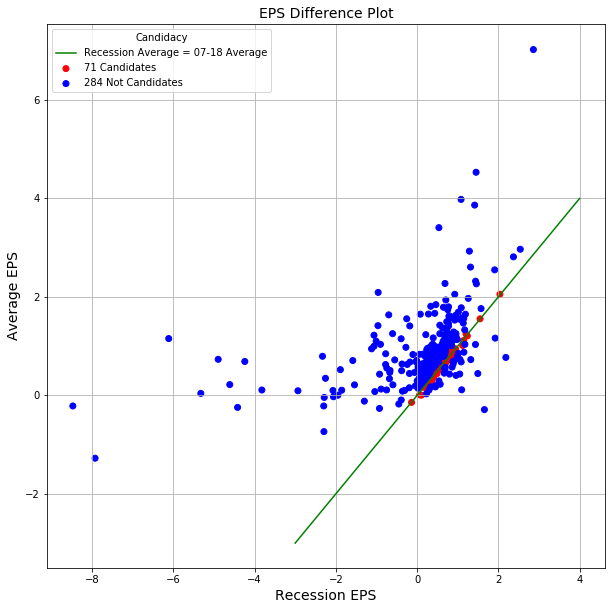

In [6]:
# plot metric decision boundary

sub_title_font =14
legend_font =8
axis_font = 10
x = np.linspace(-3, 4, 100)
y=x

fig, ax = plt.subplots(1, 1, figsize=(10,10))
cand = ax.scatter(df_cand['Recession EPS'], df_cand['Average EPS'], c=df_cand.colors, label='{} Candidates'.format(len(df_cand.index)))
not_cand = ax.scatter(df_not['Recession EPS'], df_not['Average EPS'], c=df_not.colors, label='{} Not Candidates'.format(len(df_not.index)))
line = ax.plot(x, y, c="green", label='Recession Average = 07-18 Average')

plt.xlabel('Recession EPS', fontsize=sub_title_font)
plt.ylabel('Average EPS', fontsize=sub_title_font)
plt.title('EPS Difference Plot', fontsize=sub_title_font)
ax.tick_params(axis="x", labelsize=axis_font)
ax.tick_params(axis="y", labelsize=axis_font)

plt.grid(which='major')
ax.legend(loc = 'upper left', title='Candidacy')
plt.show()

## Build Portfolio

In [7]:
# take top 30 stocks by EPS

df_cand = df_cand.sort_values(by=['Average EPS'], ascending = False)
idx_port = df_cand.head(30).index
print('Portfolio Stocks: {}'.format(idx_port))

# simplify price data to just portfolio stocks

idx_diff3 = idx_price.difference(idx_port)
df_port_price = df_price.drop(idx_diff3)


# simplify dividends data to just portfolio stocks

idx_div2 = df_div.index
idx_diff4 = idx_div2.difference(idx_port)
df_port_div = df_div.drop(idx_diff4)

Portfolio Stocks: Index(['CVX', 'XOM', 'VFC', 'BDX', 'JNJ', 'PG', 'DHR', 'BAX', 'ESS', 'DVA',
       'NKE', 'EW', 'FMC', 'AEP', 'CAH', 'GRMN', 'ADP', 'K', 'PEG', 'EMR',
       'CSX', 'CHD', 'ABC', 'ADM', 'LNT', 'CCL', 'AME', 'KO', 'T', 'EIX'],
      dtype='object', name='Stock')


## Calculate Expected Returns

In [8]:
# annual returns - not enough data points
# list start and end dates for years 2010-2018

#start_dates = ['2010-01-04', '2011-01-03', '2012-01-03', '2013-01-02', '2014-01-02', '2015-01-02', '2016-01-04', '2017-01-03', '2018-01-02']
#end_dates = ['2010-12-31', '2011-12-30', '2012-12-31', '2013-12-31', '2014-12-31', '2015-12-31', '2016-12-30', '2017-12-29', '2018-12-31']

In [9]:
# monthly returns

start_dates = ['2010-01-04', '2010-02-01', '2010-03-01', '2010-04-01', '2010-05-03', '2010-06-01', 
              '2010-07-01', '2010-08-02', '2010-09-01', '2010-10-01', '2010-11-01', '2010-12-01', 
              '2011-01-03', '2011-02-01', '2011-03-01', '2011-04-01', '2011-05-02', '2011-06-01', 
              '2011-07-01', '2011-08-01', '2011-09-01', '2011-10-03', '2011-11-01', '2011-12-01', 
              '2012-01-03', '2012-02-01', '2012-03-01', '2012-04-02', '2012-05-01', '2012-06-01', 
              '2012-07-02', '2012-08-01', '2012-09-04', '2012-10-01', '2012-11-01', '2012-12-03',
              '2013-01-02', '2013-02-01', '2013-03-01', '2013-04-01', '2013-05-01', '2013-06-03', 
              '2013-07-01', '2013-08-01', '2013-09-03', '2013-10-01', '2013-11-01', '2013-12-02', 
              '2014-01-02', '2014-02-03', '2014-03-03', '2014-04-01', '2014-05-01', '2014-06-02', 
              '2014-07-01', '2014-08-01', '2014-09-02', '2013-10-01', '2014-11-03', '2014-12-01', 
              '2015-01-02', '2015-02-02', '2015-03-02', '2015-04-01', '2015-05-01', '2015-06-01',
              '2015-07-01', '2015-08-03', '2015-09-01', '2015-10-01', '2015-11-02', '2015-12-01', 
              '2016-01-04', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-02', '2016-06-01', 
              '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-03', '2016-11-01', '2016-12-01', 
              '2017-01-03', '2017-02-01', '2017-03-01', '2017-04-03', '2017-05-01', '2017-06-01', 
              '2017-07-03', '2017-08-01', '2017-09-01', '2017-10-02', '2017-11-01', '2017-12-01', 
              '2018-01-02', '2018-02-01', '2018-03-01', '2018-04-02', '2018-05-01', '2018-06-01', 
              '2018-07-02', '2018-08-01', '2018-09-04', '2018-10-01', '2018-11-01', '2018-12-03']

end_dates = ['2010-01-29', '2010-02-26', '2010-03-31', '2010-04-30', '2010-05-28', '2010-06-30', 
            '2010-07-30', '2010-08-31', '2010-09-30', '2010-10-29', '2010-11-30', '2010-12-31', 
            '2011-01-31', '2011-02-28', '2011-03-31', '2011-04-29', '2011-05-31', '2011-06-30', 
            '2011-07-29', '2011-08-31', '2011-09-30', '2011-10-31', '2011-11-30', '2011-12-30', 
            '2012-01-31', '2012-02-29', '2012-03-30', '2012-04-30', '2012-05-31', '2012-06-29', 
            '2012-07-31', '2012-08-31', '2012-09-28', '2012-10-31', '2012-11-30', '2012-12-31', 
            '2013-01-31', '2013-02-28', '2013-03-28', '2013-04-30', '2013-05-31', '2013-06-28', 
            '2013-07-31', '2013-08-30', '2013-09-30', '2013-10-31', '2013-11-29', '2013-12-31', 
            '2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30', '2014-05-30', '2014-06-30', 
            '2014-07-31', '2014-08-29', '2014-09-30', '2014-10-31', '2014-11-28', '2014-12-31', 
            '2015-01-30', '2015-02-27', '2015-03-31', '2015-04-30', '2015-05-29', '2015-06-30', 
            '2015-07-31', '2015-08-31', '2015-09-30', '2015-10-30', '2015-11-30', '2015-12-31', 
            '2016-01-29', '2016-02-29', '2016-03-31', '2016-04-29', '2016-05-31', '2016-06-30', 
            '2016-07-29', '2016-08-31', '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-30', 
            '2017-01-31', '2017-02-28', '2017-03-31', '2017-04-28', '2017-05-31', '2017-06-30', 
            '2017-07-31', '2017-08-31', '2017-09-29', '2017-10-31', '2017-11-30', '2017-12-29', 
            '2018-01-31', '2018-02-28', '2018-03-29', '2018-04-30', '2018-05-31', '2018-06-29', 
            '2018-07-31', '2018-08-31', '2018-09-28', '2018-10-31', '2018-11-30', '2018-12-31']

# function to validate lists above

def list_diff(list1, list2):
    out = [item for item in list1 if not item in list2]
    return out

# validate start dates list

print('Missing Start Dates: {}'.format(list_diff(start_dates, list(df_price.columns))))

# validate end dates list

print('Missing End Dates: {}'.format(list_diff(end_dates, list(df_price.columns))))

Missing Start Dates: []
Missing End Dates: []


In [10]:
# calculate year end returns

temp_returns = pd.DataFrame(index=idx_port)

for start, end in zip(start_dates, end_dates):
    temp_returns[end] = df_port_price[end] - df_port_price[start]

temp_returns.sort_index(inplace=True)


# export temp returns to fix dividend data in excel

#temp_returns.to_csv('data\\processed\\temp_returns_monthly.csv')


# calculate monthly returns

temp_returns = temp_returns + df_port_div


# calculate percentage returns

df_port_returns = pd.DataFrame(index=idx_port)
df_port_returns.sort_index(inplace=True)

for start, end in zip(start_dates, end_dates):
    df_port_returns[end] = temp_returns[end]/df_port_price[start]


# calculate expected monthly returns

df_port = pd.DataFrame(index=idx_port)
df_port.sort_index(inplace=True)
df_port['expected returns'] = df_port_returns.mean(axis=1)
#df_port

## Calculate Variance of each stock

In [11]:
# putting variance values in returns in df

df_port['variance of returns'] = df_port_returns.var(axis=1)
#df_port

## Calculate Covariance Matrix

### Note: Do a Covariance Heatmap 

In [12]:
# covariance matrix

df_cov = df_port_returns.T.cov()


# check if covariance matrix is invertible
# inverse of covariance matrix

df_cov_inv = pd.DataFrame(np.linalg.inv(df_cov.values), df_cov.columns, df_cov.index)
df_cov_inv.dot(df_cov)

#cov_mat = np.cov(df_port_returns)
#cov_inv = np.linalg.inv(cov_mat)
#cov_mat.dot(cov_inv)

Stock,ABC,ADM,ADP,AEP,AME,BAX,BDX,CAH,CCL,CHD,...,JNJ,K,KO,LNT,NKE,PEG,PG,T,VFC,XOM
Stock,,,,,,,,,,,,,,,,,,,,,
ABC,1.000000e+00,2.073299e-15,4.032466e-16,1.062917e-15,1.029937e-15,3.056863e-16,1.492061e-16,1.212616e-15,8.893165e-16,9.931894e-16,...,5.402679e-15,7.651513e-16,1.715935e-15,2.193903e-15,2.550658e-15,2.199237e-15,1.681073e-15,2.385173e-15,1.552254e-15,3.868928e-15
ADM,-7.976726e-16,1.000000e+00,3.174799e-16,-9.135964e-17,-1.012082e-16,1.743701e-16,8.932666e-17,-4.964775e-16,-7.884570e-17,-2.780404e-16,...,2.241908e-16,-7.935433e-16,-9.143840e-16,-9.300766e-16,-8.512233e-16,-3.484415e-16,-5.378784e-16,-2.941066e-17,-7.769016e-18,-8.757452e-16
ADP,-2.023030e-15,-1.979132e-15,1.000000e+00,-1.419745e-15,-1.392219e-15,-1.291670e-15,-1.070164e-15,-1.837026e-15,5.333918e-16,-1.049982e-15,...,-2.105338e-15,-1.793428e-15,-2.497202e-15,-1.897522e-15,-1.077604e-15,-2.434106e-15,9.785036e-17,-1.806135e-15,-1.255261e-15,-1.825352e-15
AEP,-8.769788e-16,-2.522332e-15,6.750045e-16,1.000000e+00,2.736797e-16,-8.272876e-16,-1.183295e-15,-7.370577e-16,1.529751e-15,-1.750373e-16,...,-3.015444e-15,3.560778e-16,-2.193088e-15,-3.189449e-15,-1.265310e-15,-1.392503e-15,6.449141e-16,-7.013123e-16,-1.753093e-15,-2.572622e-15
AME,-4.251720e-16,-4.283144e-16,7.025885e-17,-2.997281e-17,1.000000e+00,-6.229001e-16,5.954770e-17,-2.187162e-16,2.531781e-17,2.016293e-16,...,-1.072957e-15,-5.945450e-16,-6.950859e-16,-6.568154e-16,-2.247468e-16,-7.701224e-16,-2.267593e-16,-1.038655e-15,-3.559919e-16,-4.180167e-16
BAX,2.302499e-16,1.877503e-16,2.902435e-16,3.151932e-16,1.933693e-16,1.000000e+00,2.047467e-16,1.637988e-16,8.873899e-17,3.014665e-16,...,-5.350748e-16,1.716756e-16,5.572136e-17,-3.390655e-16,3.026186e-16,-2.536084e-16,9.160075e-17,-1.060686e-16,9.350306e-17,1.945811e-16
BDX,2.065571e-16,1.821650e-16,-3.703873e-17,-1.488188e-16,-1.754576e-16,3.925580e-16,1.000000e+00,7.814489e-17,1.894810e-16,-1.379990e-16,...,5.199751e-16,1.415878e-16,5.151866e-16,5.385835e-16,2.606493e-17,4.908541e-16,-6.519661e-17,3.956134e-16,1.047529e-16,3.086497e-16
CAH,-9.875179e-16,-1.313309e-15,-6.272716e-16,-8.562220e-16,-6.550570e-16,-1.022169e-15,-7.076561e-16,1.000000e+00,-1.016025e-15,-9.713276e-16,...,-1.160045e-15,-1.264200e-15,-6.466349e-16,-1.720342e-16,-6.320046e-16,-9.719660e-16,-1.004424e-15,9.640854e-17,-6.387181e-16,-1.557333e-15
CCL,-1.889158e-16,-1.922948e-16,-8.217034e-17,-1.672052e-16,-1.667899e-16,-1.851848e-16,-1.316747e-16,-1.802822e-16,1.000000e+00,-1.219361e-16,...,4.774475e-18,-1.987270e-16,-1.616900e-16,-1.003489e-16,-1.841482e-16,-1.795113e-16,-8.991621e-17,-1.855226e-16,-1.354220e-16,-3.736219e-17


## Calculate Weights

In [20]:
# we need the risk free rate
# so we'll use the 3 month US treasury bond yield
# at the start of 2019

rfr = 0.0242


# create excess returns column

df_port['excess returns'] = df_port['expected returns'] - rfr


# calculate zeta vector
df_port['zeta'] = df_cov_inv.dot(df_port['excess returns'])


# normalize zeta vector to find weights

zeta_sum = df_port['zeta'].sum()
df_port['weights'] = df_port['zeta']/zeta_sum


# annualize the expected returns

df_port['annual returns'] = ((df_port['expected returns']+1)**12)-1
df_port

,expected returns,variance of returns,excess returns,zeta,weights,weighted returns,annual returns
Stock,,,,,,,
ABC,0.013597,0.002986,-0.010603,0.337536,-0.009656,0.000102,0.175936
ADM,0.027583,0.005184,0.003383,12.060868,-0.345018,-0.001167,0.386132
ADP,0.012018,0.002022,-0.012182,-11.783914,0.337095,-0.004107,0.154140
AEP,0.014155,0.002028,-0.010045,18.630305,-0.532945,0.005354,0.183726
AME,0.013058,0.004751,-0.011142,-4.735202,0.135457,-0.001509,0.168459
BAX,0.013888,0.004720,-0.010312,-0.719236,0.020575,-0.000212,0.180001
BDX,0.016396,0.002975,-0.007804,1.902036,-0.054410,0.000425,0.215501
CAH,0.012835,0.003188,-0.011365,-1.124420,0.032166,-0.000366,0.165366
CCL,0.008294,0.007200,-0.015906,-5.206298,0.148933,-0.002369,0.104190


## Evaluate Performance

In [22]:
# excess return of portfolio
# with 3 month risk free rate -0.0060748998953346

df_port['weighted returns'] = df_port['annual returns']*df_port['weights']
portfolio_return = df_port['weighted returns'].sum()
print('The Excess Return of the Portfolio: {}'.format(portfolio_return))

# risk of portfolio
# annualize by multiplying the variance by 12

weights = df_port['weights']
variance = weights.T.dot(df_cov).dot(weights)*12
portfolio_risk = np.sqrt(variance)
print('The Risk of the Portfolio: {}'.format(portfolio_risk))

# The Sharpe Ratio
# -0.16766704889940426
print('The Sharpe Ratio of the Portfolio: {}'.format(portfolio_return/portfolio_risk))

The Excess Return of the Portfolio: -0.1213705344178552
The Risk of the Portfolio: 0.10424632935622942
The Sharpe Ratio of the Portfolio: -1.1642667436577947
